In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class MLP(nn.Module):
    def __init__(self, hidden_channle=40):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [3]:
class Modified_MLP(nn.Module):
    def __init__(self, hidden_channle):
        super(Modified_MLP, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(2, hidden_channle)
        self.encodeV = nn.Linear(2, hidden_channle)
        self.In = nn.Linear(2, hidden_channle)
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, 1)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.In(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

In [4]:
nu = 0.01 / np.pi
N_u = 100
N_f = 10000
def get_TrainData():
    # 边界点X_u_train
    x_upper = np.ones((N_u//4, 1), dtype=float)
    x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u//2, 1), dtype=float)
    
    t_upper = np.random.rand(N_u//4, 1)
    t_lower = np.random.rand(N_u//4, 1)
    x_zero = np.random.rand(N_u//2, 1) * 2 -1
    
    X_upper = np.hstack((x_upper, t_upper))
    X_lower = np.hstack((x_lower, t_lower))
    X_zero = np.hstack((x_zero, t_zero))
    
    X_u_train = np.vstack((X_upper, X_lower, X_zero))
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]
    
    # 内点X_f_train
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)
        t = uniform( 0, 1)
        X_f_train[row, 0] = x
        X_f_train[row, 1] = t
    X_f_train = np.vstack((X_f_train, X_u_train))
    
    # 边界条件u_train
    u_upper =  np.zeros((N_u//4, 1), dtype=float)
    u_lower =  np.zeros((N_u//4, 1), dtype=float)
    u_zero = -np.sin(np.pi * x_zero)
    
    u_train = np.vstack((u_upper, u_lower, u_zero))
    
    u_train = u_train[index, :]
    
    x_u = torch.tensor(X_u_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
    t_u = torch.tensor(X_u_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
    
    x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
    t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
    
    u = torch.tensor(u_train, dtype=torch.float32, requires_grad=True).to(device)
    return x_u, t_u, x_f, t_f, u

In [18]:
class Train():
    def __init__(self, model_name, optimizer):
        self.model_name = model_name
        self.optimizer = optimizer
        self.loss_fn = nn.MSELoss()
        
    def Multi_Train(self, n = 5, epochs = None):
        min_L2 = 1e10
        self.min_Model = None
        self.min_Losses = None
        self.min_Result = None
        total_Losses = []
        total_Result = []
        for i in range(n):
            print(f"{i+1}/{n}")
            Losses, Result = self.One_Train(epochs = epochs)
            if Result[1] < min_L2:
                min_L2 = Result[1]
                self.min_Model = self.model
                self.min_Losses = Losses
                self.min_Result = Result
            total_Losses.append(Losses)
            total_Result.append(Result)
        self.get_Result(self.min_Model, draw = True)
        return total_Losses, total_Result
        # return np.array(total_Losses), np.array(total_Result)
        
    def One_Train(self, epochs = None):
        if self.model_name == 'MLP':
            self.model = MLP(40).to(device)
        elif self.model_name == 'Modified_MLP':
            self.model = Modified_MLP(40).to(device)
        else:
            print('Model Error')
            return None, [None]
        x_u, t_u, x_f, t_f, u = get_TrainData()
        start_time = datetime.datetime.now()
        if self.optimizer == 'Adam':
            self.model, Losses = self.Adam_train(self.model, data = [x_u, t_u, x_f, t_f, u], epochs = epochs)
        elif self.optimizer == 'LBFGS':
            self.model, Losses = self.LBFGS_train(self.model, data = [x_u, t_u, x_f, t_f, u], epochs = epochs)
        elif self.optimizer == 'SGD':
            self.model, Losses = self.SGD_train(self.model, data = [x_u, t_u, x_f, t_f, u], epochs = epochs)
        elif self.optimizer == 'RMSprop':
            self.model, Losses = self.RMSprop_train(self.model, data = [x_u, t_u, x_f, t_f, u], epochs = epochs)
        elif self.optimizer == 'Adam+LBFGS':
            self.model, Losses = self.Adam_and_LBFGS_train(self.model, data = [x_u, t_u, x_f, t_f, u])
        else:
            print('Optimizer Should Be in [Adam,LBFGS,SGD,RMSprop,Adam+LBFGS]')
            return None, [None]
            
        mse_error, l2_error = self.get_Result(self.model, draw = False)
        end_time = datetime.datetime.now()
        running_time = end_time - start_time
        print("运行时间为：", running_time.total_seconds(), "秒")
        return Losses, [mse_error, l2_error, running_time.total_seconds()]

    def u_function(self, x, t):
        u = self.model(torch.hstack((x, t)))
        return u

    def f_function(self, x, t, nu):
        u = self.u_function(x, t)
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        return u_t + u * u_x - nu * u_xx
    
    def get_Loss(self, u, x_u, t_u, x_f, t_f, nu):
        u_pre = self.u_function(x_u, t_u)
        f_pre = self.f_function(x_f, t_f, nu)
        
        Zero =  torch.zeros((x_f.shape[0], 1)).to(device)
        u_loss = self.loss_fn(u_pre, u)
        f_loss = self.loss_fn(f_pre, Zero)
        ls = u_loss + f_loss
        return ls

    def Losses_Analyse(self, total_Losses, total_Result):
        if len(total_Losses) == 0 or len(total_Result) == 0:
            print(f"Result Error")
            return
        mean_loss = np.mean(total_Losses, axis=0)
        max_loss = np.max(total_Losses, axis=0)
        min_loss = np.min(total_Losses, axis=0)
        epochs = np.arange(total_Losses.shape[1])
        plt.figure(figsize=(5, 4))
        plt.plot(epochs, np.log(mean_loss), color='blue', label='Mean Loss')
        plt.fill_between(epochs, np.log(min_loss), np.log(max_loss), color='blue', alpha=0.2, label='Min-Max Range')
        plt.xlabel('Epoch')
        plt.ylabel('log(Loss)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        threshold = 1e-2
        converge_epochs_2 = np.mean([np.argmax(run < threshold) if np.any(run < threshold) else 0 for run in total_Losses])
        threshold = 1e-3
        converge_epochs_3 = np.mean([np.argmax(run < threshold) if np.any(run < threshold) else 0 for run in total_Losses])
        threshold = 1e-4
        converge_epochs_4 = np.mean([np.argmax(run < threshold) if np.any(run < threshold) else 0 for run in total_Losses])
        print("Mean Convergence Epochs:", "1E-2:",converge_epochs_2,"1E-3:",converge_epochs_3,"1E-4:",converge_epochs_4)
        print("Mean Final Loss:", np.mean(total_Losses[:, -1]))

        plt.figure(figsize=(18,4))
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.boxplot(total_Result[:,i], patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=6, linestyle='none'))
            plt.xticks([1],[['MSE Error', 'L2 Relative Error', 'Running Time (s)'][i]])
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
        plt.show()

        mean_Result = np.mean(total_Result,axis=0)
        print("Mean MSE:",mean_Result[0],"Mean Related L2:",mean_Result[1],"Mean Running Time:",mean_Result[2])
        
    def Adam_train(self, model, data, epochs = None):
        if not epochs:
            epochs = 10000
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1)
        Losses = []
        x_u, t_u, x_f, t_f, u = data
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            Losses.append(loss.item())
            if epoch % 500 ==0:
                print(f"[Adam Epoch {epoch+1}/{epochs}] [loss: {loss.item():.4e}]")
            optimizer.step()
            scheduler.step()
        return model, Losses
    
    def LBFGS_train(self, model, data, epochs=None):
        if not epochs:
            epochs = 500
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, max_eval=None, history_size=100, line_search_fn="strong_wolfe")
        Losses = []
        x_u, t_u, x_f, t_f, u = data
        def closure():
            optimizer.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            return loss
        for epoch in range(epochs):
            loss = optimizer.step(closure)
            Losses.append(loss.item())
            if epoch % 10 == 0:
                print(f"[LBFGS Epoch {epoch+1}/{epochs}] [loss: {loss.item():.4e}]")
        return model, Losses
    
    def Adam_and_LBFGS_train(self, model, data, epochs_adam = None, epochs_lbfg = None):
        if not epochs_adam:
            epochs_adam = 5000
        if not epochs_lbfg:
            epochs_lbfg = 200
        Losses_adam = []
        Losses_lbfgs = []
        x_u, t_u, x_f, t_f, u = data
        # ---------- Phase 1: Adam ----------
        optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=epochs_adam//4, gamma=0.1)
        
        for epoch in range(epochs_adam):
            optimizer_adam.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            optimizer_adam.step()
            scheduler.step()
            Losses_adam.append(loss.item())
            if epoch % 500 == 0:
                print(f"[Adam Epoch {epoch+1}/{epochs_adam}] [Loss: {loss.item():.4e}]")
                
        # ---------- Phase 2: LBGF ----------
        optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, history_size=100, line_search_fn='strong_wolfe')
        def closure():
            optimizer_lbfgs.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            Losses_lbfgs.append(loss.item())
            return loss
        print("Starting L-BFGS optimization...")
        for epoch in range(epochs_lbfg):
            loss = optimizer.step(closure)
            if epoch % 10 == 0:
                print(f"[LBFGS Epoch {epoch+1}/{epochs_lbfg}] [loss: {loss.item():.4e}]")
        total_losses = Losses_adam + Losses_lbfgs
        return model, total_losses
    
    def RMSprop_train(self, model, data, epochs = None):
        if not epochs:
            epochs = 10000
        Losses = []
        x_u, t_u, x_f, t_f, u = data
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            optimizer.step()
            scheduler.step()
            Losses.append(loss.item())
            if epoch % 500 == 0:
                print(f"[RMSprop Epoch {epoch+1}/{epochs}] [Loss: {loss.item():.4e}]")
        return model, Losses
    
    def SGD_train(self, model, data, epochs = None):
        if not epochs:
            epochs = 10000
        Losses = []
        x_u, t_u, x_f, t_f, u = data
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.get_Loss(u, x_u, t_u, x_f, t_f, nu)
            loss.backward()
            optimizer.step()
            scheduler.step()
            Losses.append(loss.item())
            if epoch % 500 == 0:
                print(f"[SGD Epoch {epoch+1}/{epochs}] [Loss: {loss.item():.4e}]")
        return model, Losses
        
    def get_Result(self, model, draw = False):
        data = loadmat('burgers_shock.mat')
        x = data['x'].flatten()
        t = data['t'].flatten()
        u = data['usol']
        T, X = np.meshgrid(t, x)
        T_ = torch.tensor(T.reshape(-1,1), dtype=torch.float32, requires_grad=True).to(device)
        X_ = torch.tensor(X.reshape(-1,1), dtype=torch.float32, requires_grad=True).to(device)
        u_pre = model(torch.hstack((X_, T_))).cpu().detach().numpy().reshape(-1, 1)
        mse_error = np.mean((u_pre - u.reshape(-1,1))**2)
        l2_error = np.linalg.norm(u_pre - u.reshape(-1,1)) / np.linalg.norm(u.reshape(-1,1))
        print(f"MSE误差: {mse_error:.4e}")
        print(f"L2 相对误差: {l2_error.item():.4e}")

        if draw:
            plt.figure(figsize=(18,4))
            plt.subplot(1,3,1)
            scatter = plt.scatter(T.flatten(), X.flatten(), c=u.flatten(), cmap='bwr')
            plt.colorbar()
            plt.xlabel('t')
            plt.ylabel('x')
            plt.title('Exact')
            plt.tight_layout()
            
            plt.subplot(1,3,2)
            scatter = plt.scatter(T.flatten(), X.flatten(), c=u_pre.flatten(), cmap='bwr')
            plt.colorbar()
            plt.xlabel('t')
            plt.ylabel('x')
            plt.title('Pre')
            plt.tight_layout()
            
            plt.subplot(1,3,3)
            scatter = plt.scatter(T.flatten(), X.flatten(), c=np.abs(u.flatten()-u_pre.flatten()), cmap='bwr')
            plt.colorbar()
            plt.xlabel('t')
            plt.ylabel('x')
            plt.title('Error')
            plt.tight_layout()
            plt.show()
            
            self.plot_t(data,model)
        return mse_error, l2_error

    def plot_t(self, data, model):
        plt.figure(figsize=(18,4))
        for i,m in enumerate([0.25,0.5,0.75]):
            plt.subplot(1,3,i+1)
            x = np.linspace(-1, 1, 200)
            t = np.full_like(x, m)
            
            x, t = x.reshape(-1,1), t.reshape(-1,1)
            xcol = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
            tcol = torch.tensor(t, dtype=torch.float32, requires_grad=True).to(device)
            
            u_pre = model(torch.hstack((xcol, tcol))).cpu().detach().numpy().reshape(-1, 1)
            
            x_ = data['x'].flatten()
            t_ = data['t'].flatten()
            u_ = data['usol']
            idx = np.abs(t_ - m).argmin()

            plt.plot(x, u_pre, label = 'Pre')
            plt.plot(x_, u_[:, idx], '--', label=f't = {m}')
            plt.legend()
        plt.show()

1/10


E:\anaconda3\envs\py39\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[SGD Epoch 1/10000] [Loss: 6.4240e-01]
[SGD Epoch 501/10000] [Loss: 9.3646e-02]
[SGD Epoch 1001/10000] [Loss: 7.9282e-02]
[SGD Epoch 1501/10000] [Loss: 6.1477e-02]
[SGD Epoch 2001/10000] [Loss: 5.5779e-02]
[SGD Epoch 2501/10000] [Loss: 5.1673e-02]
[SGD Epoch 3001/10000] [Loss: 5.1319e-02]
[SGD Epoch 3501/10000] [Loss: 5.0975e-02]
[SGD Epoch 4001/10000] [Loss: 5.0639e-02]
[SGD Epoch 4501/10000] [Loss: 5.0312e-02]
[SGD Epoch 5001/10000] [Loss: 4.9993e-02]
[SGD Epoch 5501/10000] [Loss: 4.9962e-02]
[SGD Epoch 6001/10000] [Loss: 4.9930e-02]
[SGD Epoch 6501/10000] [Loss: 4.9899e-02]
[SGD Epoch 7001/10000] [Loss: 4.9868e-02]
[SGD Epoch 7501/10000] [Loss: 4.9837e-02]
[SGD Epoch 8001/10000] [Loss: 4.9834e-02]
[SGD Epoch 8501/10000] [Loss: 4.9831e-02]
[SGD Epoch 9001/10000] [Loss: 4.9828e-02]
[SGD Epoch 9501/10000] [Loss: 4.9825e-02]
MSE误差: 8.6314e-02
L2 相对误差: 4.7823e-01
运行时间为： 366.424277 秒
2/10
[SGD Epoch 1/10000] [Loss: 4.8250e-01]
[SGD Epoch 501/10000] [Loss: 9.5715e-02]
[SGD Epoch 1001/10000

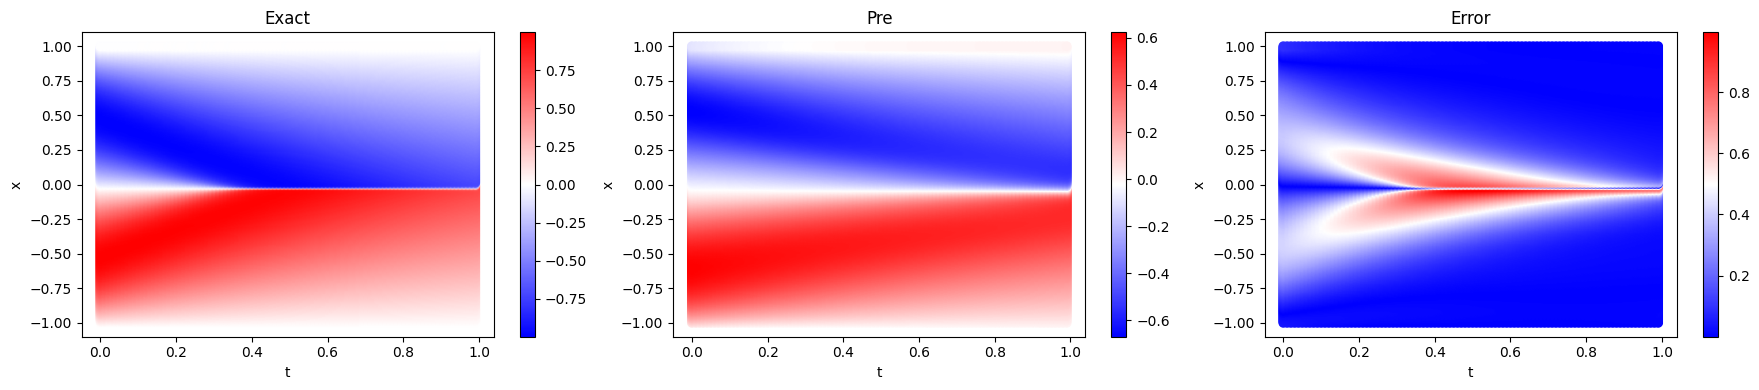

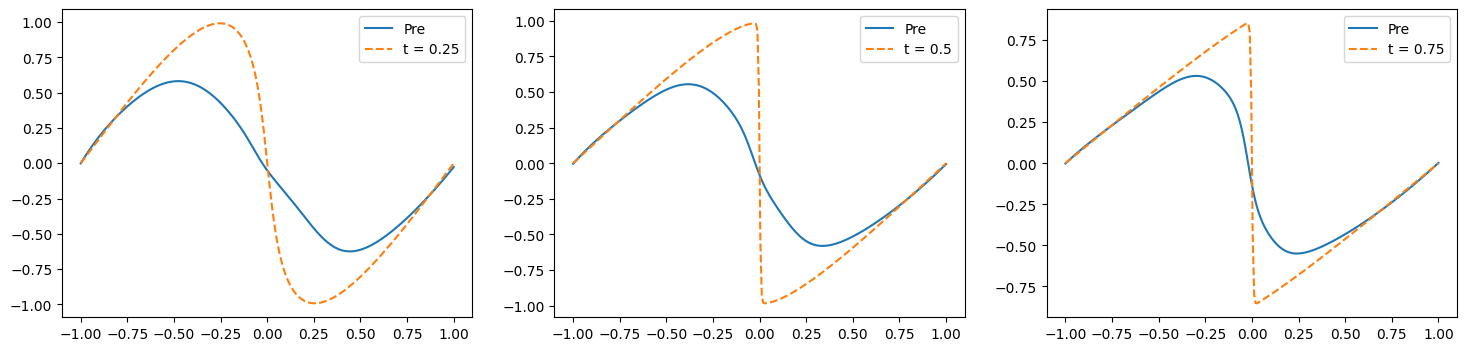

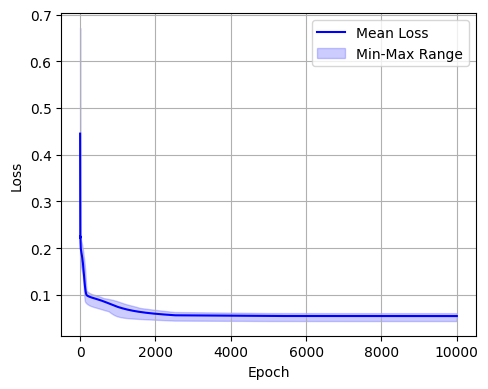

Mean Convergence Epochs: 0.0
Mean Final Loss: 0.0547202218323946


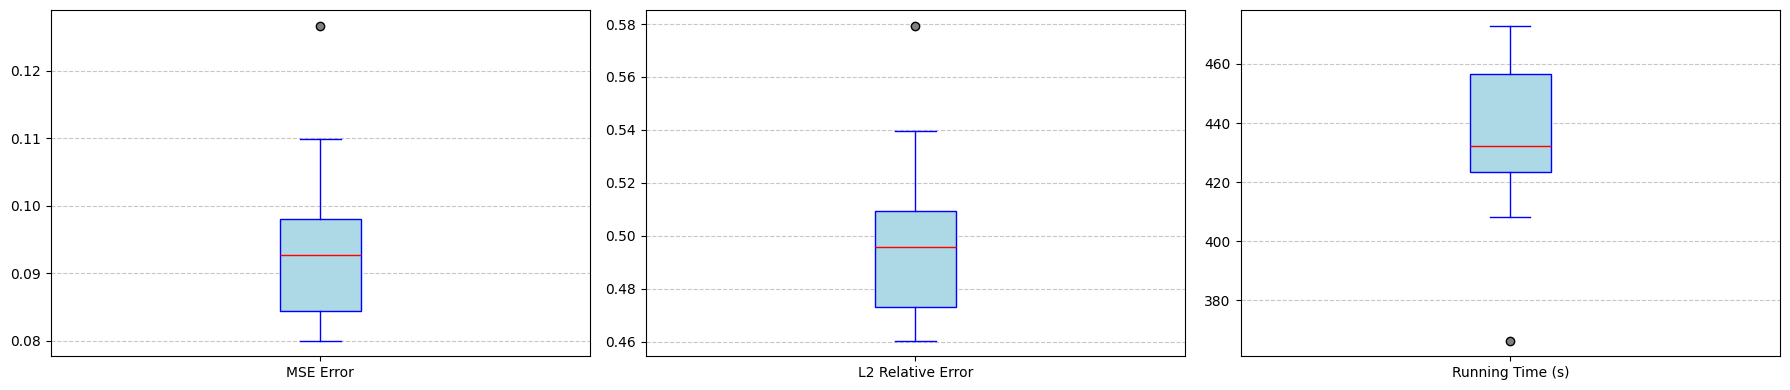

Mean MSE: 0.09484800354344117 Mean Related L2: 0.5000989921552866 Mean Running Time: 434.2539971


In [6]:
PINNs = Train('Modified_MLP','SGD')
total_Losses, total_Result = PINNs.Multi_Train(n = 10, epochs = None)
PINNs.Losses_Analyse(total_Losses, total_Result)

1/10
[Adam Epoch 1/10000] [loss: 6.9844e-01]
[Adam Epoch 501/10000] [loss: 5.6396e-03]
[Adam Epoch 1001/10000] [loss: 1.8153e-03]
[Adam Epoch 1501/10000] [loss: 1.8940e-02]
[Adam Epoch 2001/10000] [loss: 1.5589e-03]
[Adam Epoch 2501/10000] [loss: 5.4625e-04]
[Adam Epoch 3001/10000] [loss: 5.2630e-05]
[Adam Epoch 3501/10000] [loss: 4.3650e-05]
[Adam Epoch 4001/10000] [loss: 3.6200e-05]
[Adam Epoch 4501/10000] [loss: 2.8731e-05]
[Adam Epoch 5001/10000] [loss: 2.2985e-05]
[Adam Epoch 5501/10000] [loss: 2.2457e-05]
[Adam Epoch 6001/10000] [loss: 2.1825e-05]
[Adam Epoch 6501/10000] [loss: 2.1078e-05]
[Adam Epoch 7001/10000] [loss: 2.0213e-05]
[Adam Epoch 7501/10000] [loss: 1.9227e-05]
[Adam Epoch 8001/10000] [loss: 1.9110e-05]
[Adam Epoch 8501/10000] [loss: 1.8961e-05]
[Adam Epoch 9001/10000] [loss: 1.8775e-05]
[Adam Epoch 9501/10000] [loss: 1.8543e-05]
MSE误差: 3.0197e-04
L2 相对误差: 2.8286e-02
运行时间为： 474.529464 秒
2/10
[Adam Epoch 1/10000] [loss: 4.0834e-01]
[Adam Epoch 501/10000] [loss: 3.8126

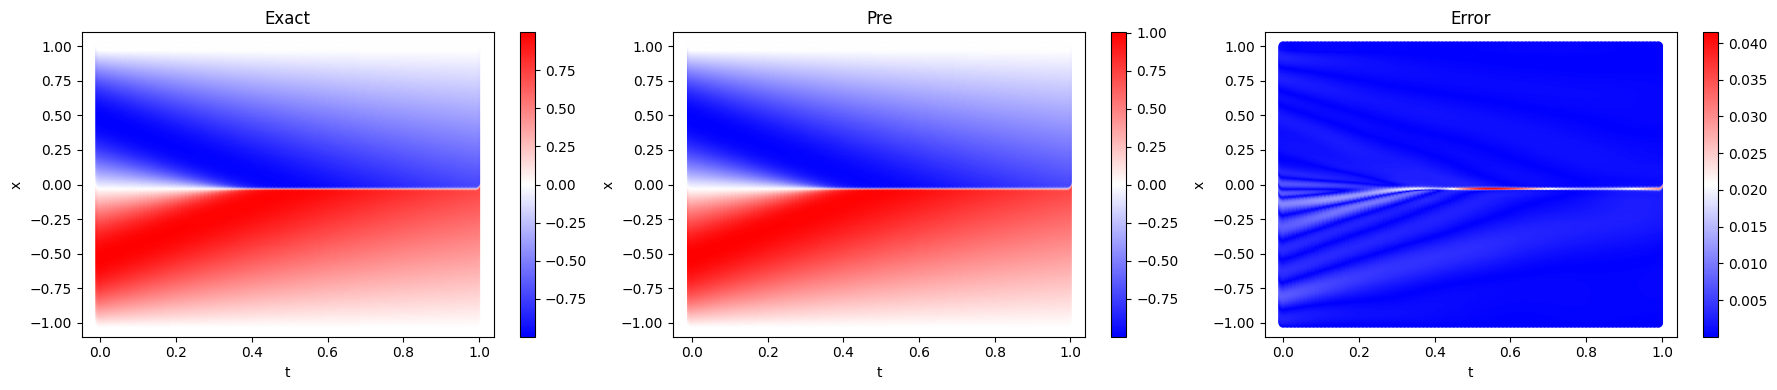

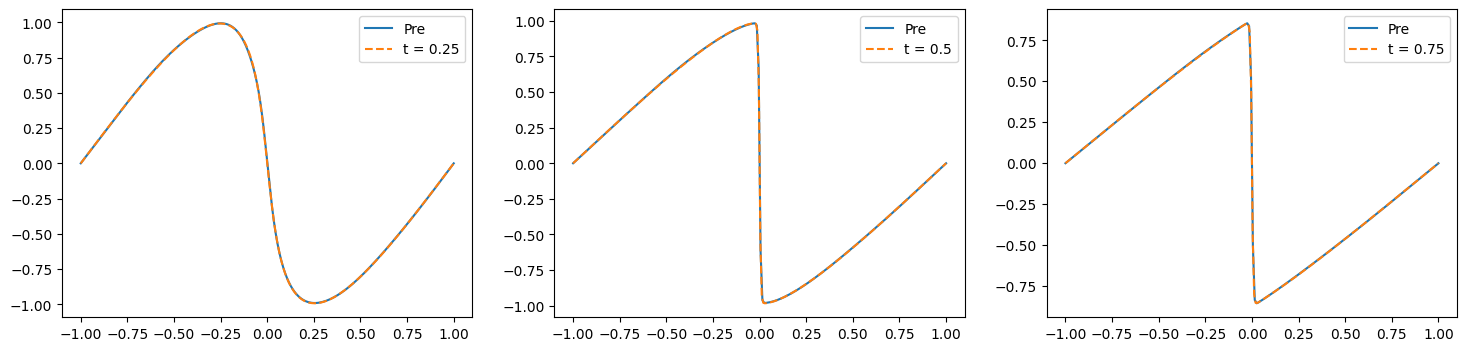

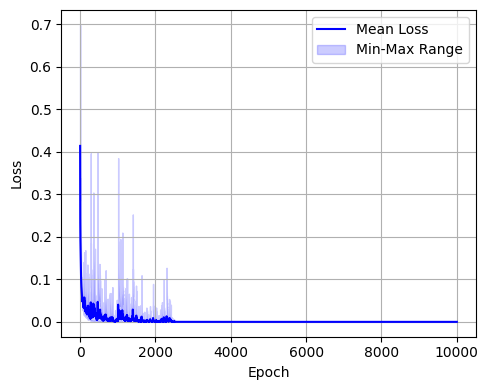

Mean Convergence Epochs: 0.0
Mean Final Loss: 1.874525405582972e-05


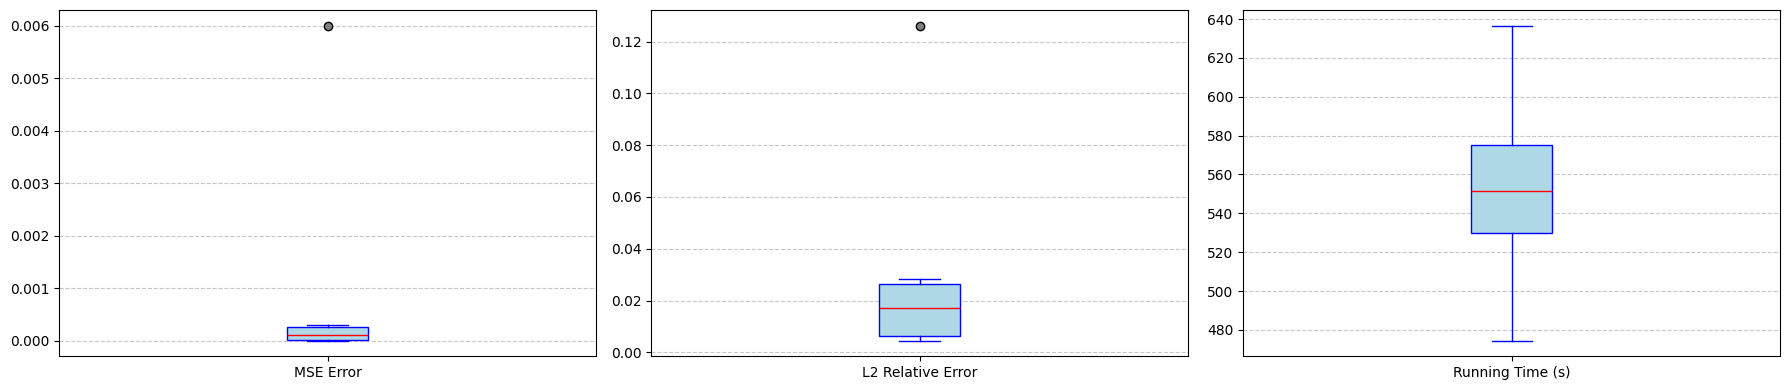

Mean MSE: 0.0007080182261858285 Mean Related L2: 0.026283374453404413 Mean Running Time: 552.3572811


In [7]:
PINNs = Train('Modified_MLP','Adam')
total_Losses, total_Result = PINNs.Multi_Train(n = 10, epochs = None)
PINNs.Losses_Analyse(total_Losses, total_Result)

In [8]:
PINNs = Train('Modified_MLP','LBFGS')
total_Losses, total_Result = PINNs.Multi_Train(n = 10, epochs = None)
PINNs.Losses_Analyse(total_Losses, total_Result)

In [ ]:
PINNs = Train('Modified_MLP','RMSprop')
total_Losses, total_Result = PINNs.Multi_Train(n = 10, epochs = None)
PINNs.Losses_Analyse(total_Losses, total_Result)

1/10


E:\anaconda3\envs\py39\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[RMSprop Epoch 1/10000] [Loss: 3.6120e-01]


In [ ]:
PINNs = Train('Modified_MLP','Adam+LBFGS')
total_Losses, total_Result = PINNs.Multi_Train(n = 10, epochs = None)
PINNs.Losses_Analyse(total_Losses, total_Result)